<a href="https://colab.research.google.com/github/XinyingXu/MMF1928-Project-1/blob/main/MMF_1928_Project_1_Q2_a).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set Up**

In [ ]:
#import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#set up parameters
T = 1 #maturity time
S0 = 10 #initial price
mu = 0.05 #drift
sigma = 0.2 #volatility
r = 0.02 #risk-free rate
N = 5000 #number of steps
K = 10 #strike price
Delta_t = T/N

In [ ]:
qb = (1-np.exp((-sigma) * np.sqrt(Delta_t)))/(np.exp(sigma * np.sqrt(Delta_t))-np.exp((-sigma) * np.sqrt(Delta_t)))
print(qb)

0.49929289369021107


In [ ]:
qs = (1-np.exp((sigma) * np.sqrt(Delta_t)))/(np.exp((-sigma) * np.sqrt(Delta_t))-np.exp((sigma) * np.sqrt(Delta_t)))
print(qs)

0.5007071063097791


## **Part 2(a) i**
i. Plot the exercise boundary as a function of t for both approaches.

In [ ]:
# Set up the binomial tree model of the American option
def American_Option(T, S0, mu, sigma, r, N, K):
  #define Delta t
  Delta_t = T/N

  #define probability measures
  qb = (1-np.exp((-sigma) * np.sqrt(Delta_t)))/(np.exp(sigma * np.sqrt(Delta_t))-np.exp((-sigma) * np.sqrt(Delta_t))) #using B as numeraire
  qs = (1-np.exp((sigma) * np.sqrt(Delta_t)))/(np.exp((-sigma) * np.sqrt(Delta_t))-np.exp((sigma) * np.sqrt(Delta_t))) #using S as numeraire

  #multiplication coefficient for the asset price
  ku = np.exp(r * Delta_t + sigma * np.sqrt(Delta_t)) #going up
  kd = np.exp(r * Delta_t - sigma * np.sqrt(Delta_t)) #going down

  #model the binomial tree of asset price S
  S = np.full((N+1, N+1), np.nan)

  #set up the initial price
  S[0,0] = S0

  #fill the tree
  for i in range(1,N+1):
    S[0:i, i] = S[0:i, i-1] * ku #we set up the matrix in this way because it is a recombining tree
    S[i, i] = S[i-1, i-1] * kd

  #set up the value tree
  Vb = np.full((N+1, N+1), np.nan) #using B as numeraire
  Vs = np.full((N+1, N+1), np.nan) #using S as numeraire

  #an array to store the exercise boundary
  exercise_boundary_b = np.full((N+1), np.nan)
  exercise_boundary_s = np.full((N+1), np.nan)

  #evaluate the payoff at time T
  Vb[:, -1] = np.maximum(K - S[:, -1], 0)
  Vs[:, -1] = np.maximum(K - S[:, -1], 0)

  #fill the hold value tree using backward induction
  for i in range(N, -1, -1):
    Vb[0:i, i-1] = np.exp(-r*Delta_t)*(qb*Vb[0:i, i]+(1-qb)*Vb[1:i+1, i])
    Vb[0:i, i-1] = np.maximum(K - S[0:i, i-1], Vb[0:i, i-1])

    Vs[0:i, i-1] = S[0:i, i-1]*(qs*Vs[0:i, i]/S[0:i, i]+(1-qs)*Vs[1:i+1, i]/S[1:i+1, i])
    Vs[0:i, i-1] = np.maximum(K - S[0:i, i-1], Vs[0:i, i-1])

    #locate exercise boundaries
    boundary_s = 0
    boundary_b = 0
    while boundary_b < N+1:
      if (Vb[boundary_b, i] > (K-S[boundary_b,i])):
        boundary_b += 1
      else: break
    while boundary_s < N+1:
      if (Vs[boundary_s, i] > (K-S[boundary_s,i]) ):
        boundary_s += 1
      else: break

    exercise_boundary_b[i] = S[boundary_b+1, i]
    exercise_boundary_s[i] = S[boundary_s+1, i]

  #return the exercise boundary, option price tree S, option value trees, and initial option values
  return exercise_boundary_b, exercise_boundary_s, S, Vb, Vs, Vb[0,0], Vs[0,0]


In [ ]:
#apply the American Option model to our parameters
bdr_b, bdr_s, S, V, Vs, V0, V0_s = American_Option(T, S0, mu, sigma, r, N, K)

In [ ]:
#print the option price
print ("Option price using B as numeraire is: "+str(V0))

Option price using B as numeraire is: 0.7111204377848224


In [ ]:
#print the option price
print ("Option price using S as numeraire is: "+str(V0_s))

Option price using S as numeraire is: 0.7111204377852156


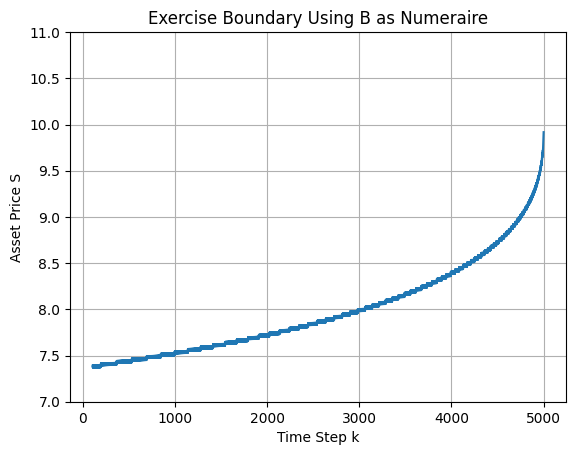

In [ ]:
#plot the boundaries
plt.ylim(7, 11)

# Plot the array
plt.plot(bdr_b)

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
#plt.legend(loc='upper right')
plt.title('Exercise Boundary Using B as Numeraire')

# Show the plot
plt.grid(True)
plt.show()

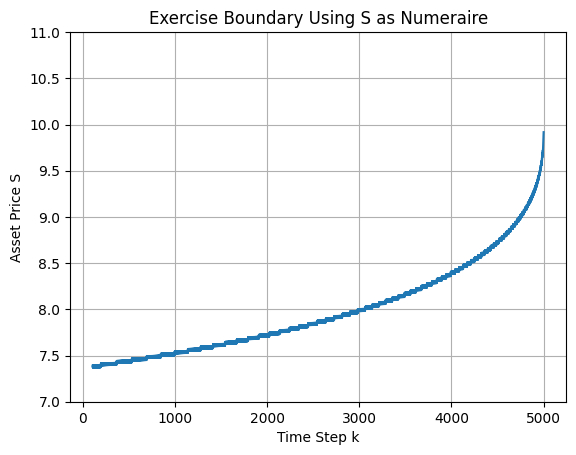

In [ ]:
#plot the boundaries
plt.ylim(7, 11)

# Plot the array
time = range(1, len(bdr_s) + 1)
plt.plot(bdr_s)

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
#plt.legend(loc='upper right')
plt.title('Exercise Boundary Using S as Numeraire')

# Show the plot
plt.grid(True)
plt.show()

## **Part 2(a) ii**
ii. Generate two sample paths where in sample path
1.   the option is exercised early (say around t = 1/2 )
2.   the option is not exercised



In [ ]:
import random

# Define a function to move either right or right-down
def move(x, y, r, sigma):
  if random.random() < (1/2)*(1+((mu-r)-1/2*(sigma**2))/(sigma)*np.sqrt(Delta_t)): #use the physical probability measure P
      return (x , y+1)
  else:
      return (x + 1, y + 1)

# define a function that generates a sample path in X intersecting Y at approximately n/2
def generate_sample_path_half(matrix_size, X, Y, r, sigma):
  n = matrix_size+1

  # generate a sample path
  while True:
    path = [(0,0)]
    sample_path = [X[0,0]]
    while len(path) < n:
      x, y = path[-1]
      x, y = move(x, y, r, sigma)
      path.append((x, y))
      sample_path.append(X[x,y])
      if (X[x,y] == Y[y]):
        if (len(path) in range(n//2-1, n//2+1)):
          sample_path_half = sample_path
          return sample_path_half, path
        else: break

In [ ]:
#calculate the path using B as numeraire
sample_path_half, path_half = generate_sample_path_half(N, S, bdr_b, r, sigma)

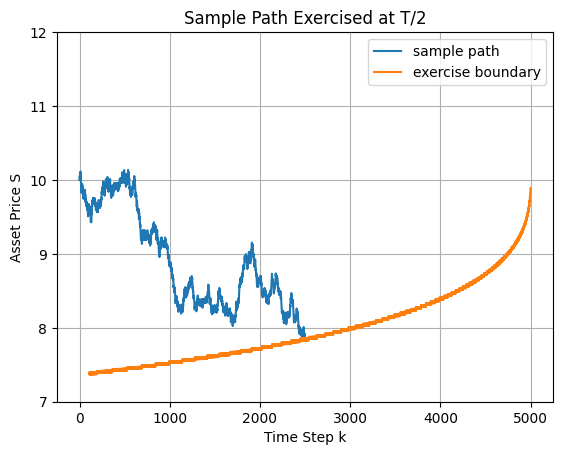

In [ ]:
#plot the path
plt.ylim(7,12)

# Plot the array
#time = range(1, len(bdr_s) + 1)
plt.plot(sample_path_half, label = 'sample path')
plt.plot(bdr_b, label = 'exercise boundary')

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
plt.legend(loc='upper right')
plt.title('Sample Path Exercised at T/2')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
# define a function that generates a sample path in X with no intersection with Y
def generate_sample_path_no_exercise(matrix_size, X, Y, r, sigma):
  n = matrix_size+1

  # generate a sample path
  while True:
    path = [(0,0)]
    sample_path = [X[0,0]]
    while len(path) < n:
      x, y = path[-1]
      x, y = move(x, y, r, sigma)
      path.append((x, y))
      sample_path.append(X[x,y])
      if (X[x,y] == Y[y]):
        del path[-1]
        break
      else: continue
    if (len(path) == N): return sample_path, path

In [ ]:
#calculate the path using B as numeraire
sample_path_no_exercise, path_no_exercise = generate_sample_path_no_exercise(N, S, bdr_b, r, sigma)

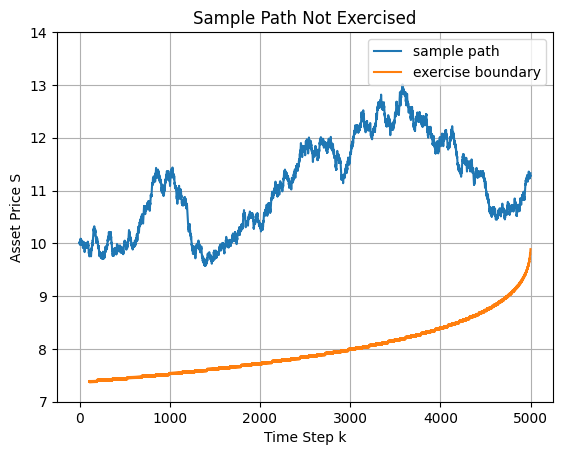

In [ ]:
#plot the path
plt.ylim(7,14)

# Plot the array
#time = range(1, len(bdr_s) + 1)
plt.plot(sample_path_no_exercise, label = 'sample path')
plt.plot(bdr_b, label = 'exercise boundary')

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
plt.legend(loc='upper right')
plt.title('Sample Path Not Exercised')

# Show the plot
plt.grid(True)
plt.show()

## **Part 2(a) iii**
iii. Along the two sample paths above, plot the hedging strategy that a trader would use to hedge
the option as a function of time.


In [ ]:
# define the hedging strategy
def hedging_strategy(path, V, S, N, r, Delta_t):
  # calculate alpha
  alpha = np.full((len(path)), np.nan)
  beta = np.full((len(path)), np.nan)

  # calculate alpha_0
  x0, y0 = path[0]
  alpha[0] = (V[x0, y0+1]-V[x0+1, y0+1])/(S[x0, y0+1] - S[x0+1, y0+1])

  # fill the array
  for i in range(1, len(path)-1):
      x, y = path[i]
      alpha[i] = (V[x, y+1]-V[x+1, y+1])/(S[x, y+1] - S[x+1, y+1])

  # calculate the bank account
  B = np.full((N+1,N+1), np.nan)
  B[0,0] = 1

  for i in range(0, N+1):
    B[0:i, i] = np.exp(r*i*Delta_t)

  # calculate beta_0
  x0, y0 = path[0]
  beta[0] = (V[x0, y0+1] - alpha[0]*S[x0, y0+1]) / B[x0, y0+1]

  # fill the beta array
  for i in range(1, len(path)-1):
    x, y = path[i]
    beta[i] = (V[x, y+1]-alpha[i]*S[x, y+1]) / B[x, y+1]

  return alpha, beta

In [ ]:
alpha_half, beta_half = hedging_strategy(path_half, V, S, N, r, T/N)

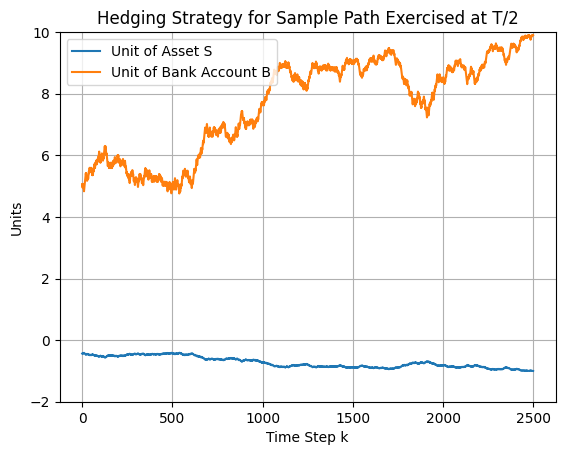

In [ ]:
#plot the hedging strategy
plt.ylim(-2, 10)

# Plot the array
plt.plot(alpha_half, label = 'Unit of Asset S')
plt.plot(beta_half, label = 'Unit of Bank Account B')

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Units')
plt.legend(loc='upper left')
plt.title('Hedging Strategy for Sample Path Exercised at T/2')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
alpha_no_exercise, beta_no_exercise = hedging_strategy(path_no_exercise, V, S, N, r, T/N)

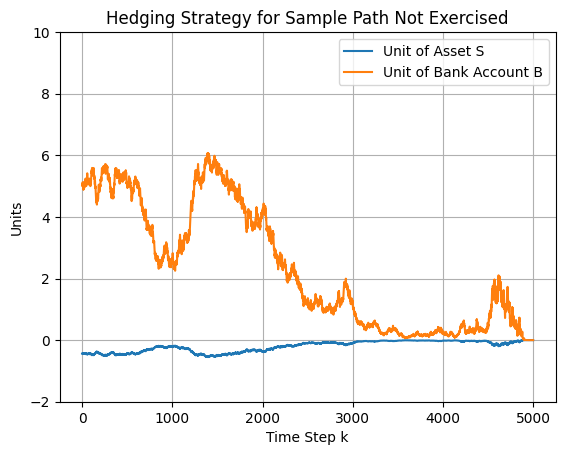

In [ ]:
#plot the hedging strategy
plt.ylim(-2, 10)

# Plot the array
plt.plot(alpha_no_exercise, label = 'Unit of Asset S')
plt.plot(beta_no_exercise, label = 'Unit of Bank Account B')

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Units')
plt.legend(loc='upper right')
plt.title('Hedging Strategy for Sample Path Not Exercised')

# Show the plot
plt.grid(True)
plt.show()

## **Part 2(a) iv**
iv. Illustrate how the results in i,ii, and iii vary as volatility and risk-free rate change (pair-wise).
[For example, σ = 10%, 20%, 30% and r = 0%, 2%, 4%]

In [ ]:
#try different values for part i
r_1 = 0.001
bdr_b_1, bdr_s_1, S_1, V_1, Vs_1, V0_1, V0_s_1  = American_Option(T, S0, mu, 0.1, r_1, N, K)

In [ ]:
bdr_b_2, bdr_s_2, S_2, V_2, Vs_2, V0_2, V0_s_2  = American_Option(T, S0, mu, 0.3, 0.04, N, K)

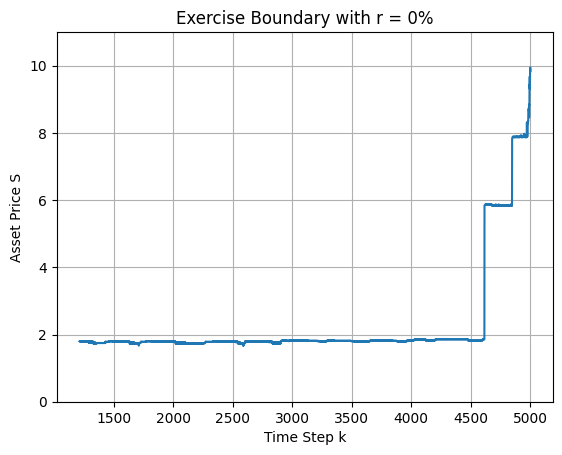

In [ ]:
bdr_b_0, bdr_s_0, S_0, V_0, Vs_0, V0_0, V0_s_0  = American_Option(T, S0, mu, 0.1, 0, N, K)
#plot the boundaries
plt.ylim(0, 11)

# Plot the array
plt.plot(bdr_b_0)

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
#plt.legend(loc='upper right')
plt.title('Exercise Boundary with r = 0%')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
#define the parameter list
r_list = [0.001, 0.02, 0.04]
sigma_list = [0.1, 0.2, 0.3]

In [ ]:
# define a function that generates a sample path in X intersecting Y
def generate_sample_path_early_exercise(matrix_size, X, Y, r, sigma):
  n = matrix_size

  # generate a sample path
  while True:
    path = [(0,0)]
    sample_path = [X[0,0]]
    while len(path) < N:
      x, y = path[-1]
      x, y = move(x, y, r, sigma)
      path.append((x, y))
      sample_path.append(X[x,y])
      if (X[x,y] == Y[y]):
        if (len(path) < N):
          return sample_path, path
        else: break

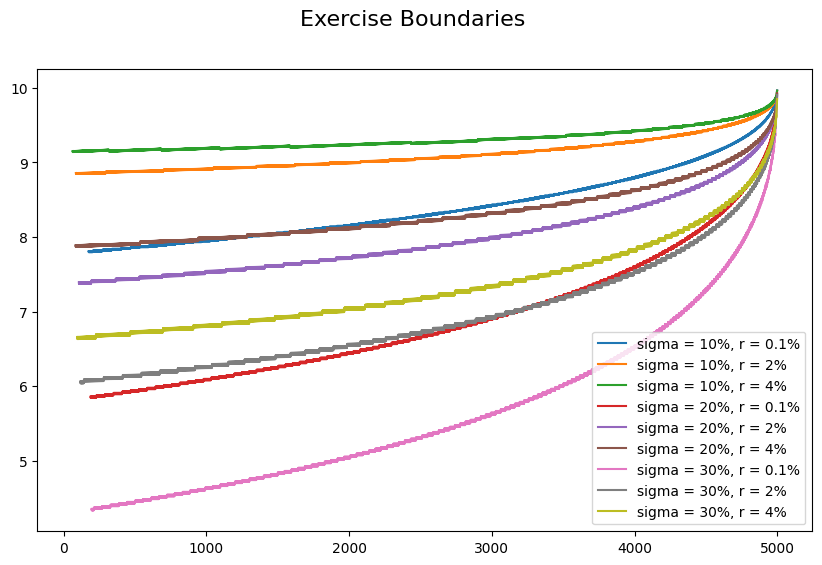

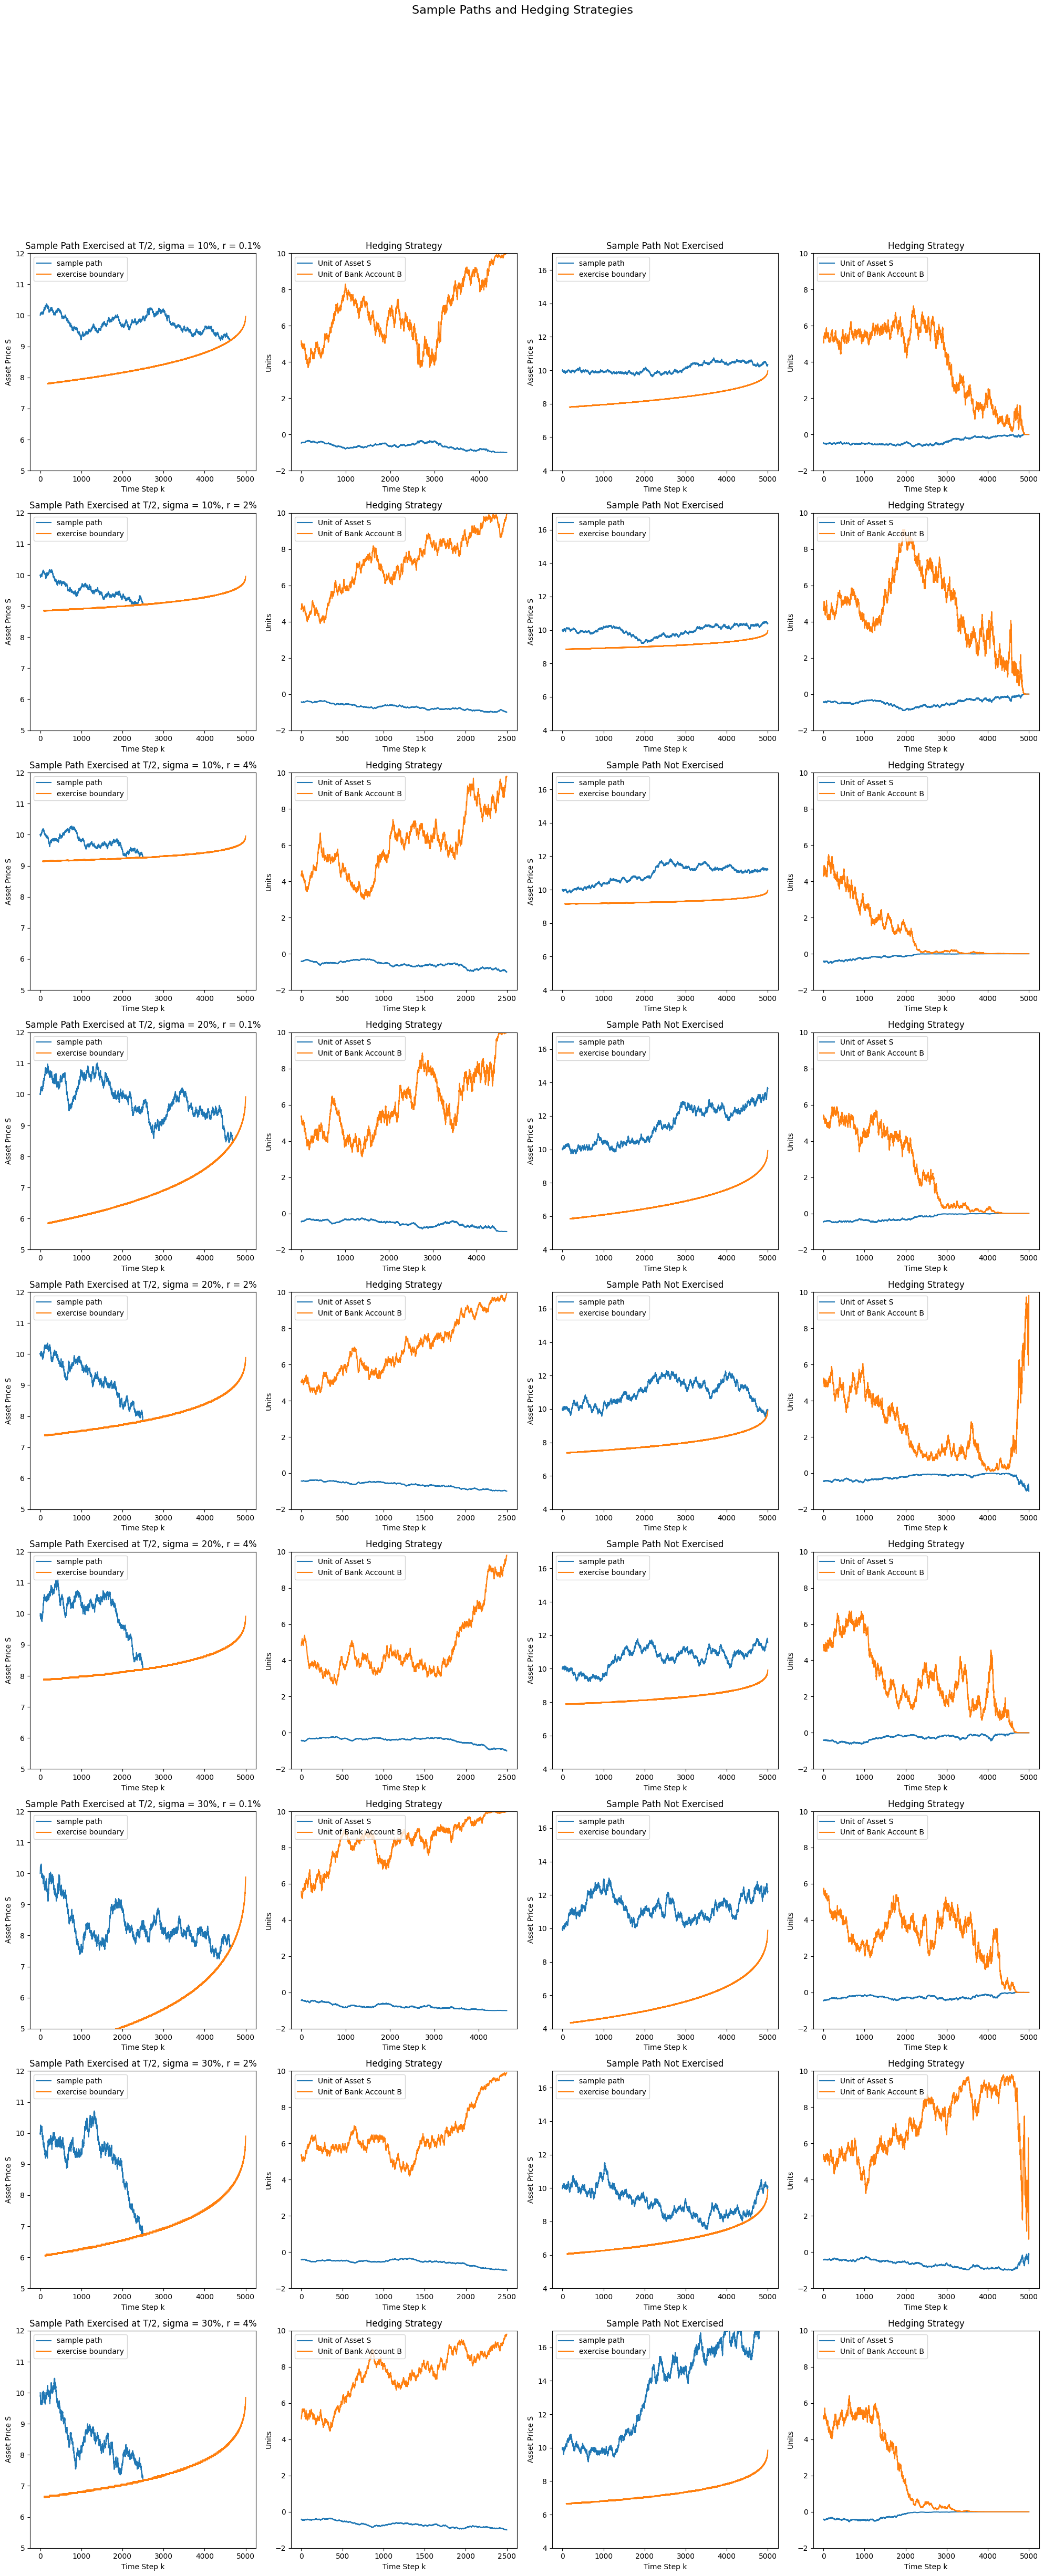

In [ ]:
#plot all boundaries

# Create a figure for the line graph with 9 lines
fig1, axs1 = plt.subplots(figsize=(10, 6))
fig1.suptitle('Exercise Boundaries', fontsize=16)

# Create a figure with 9*4 subplots
fig2, axs2 = plt.subplots(9, 4, figsize=(20, 50))
fig2.suptitle('Sample Paths and Hedging Strategies', fontsize=16)

for i in range(3):
    # Line Graph (1) - Create 9 lines
    #axs1.plot(data[i], label=f'Line {i * 3 + 1}')

    for j in range(3):
        #calculate boundary
        sigma_real = sigma_list[i]
        r_real = r_list[j]
        bdr_b_real, bdr_s_real, S_real, V_real, Vs_real, V0_real, V0_s_real  = American_Option(T, S0, mu, sigma_real, r_real, N, K)

        # subplot (1)
        axs1.plot(bdr_b_real, label=f'sigma = '+str("%g" % (sigma_real*100))+'%, r = '+str("%g" % (r_real*100))+'%')

        # calculate sample paths and hedging strategies
        if (r_real == 0.001):
          # with r = 0.1%, the possibility of exercised at T/2 is minimal
          # hence we are generating a sample path that is early exercised instead
          sample_path_half_real, path_half_real = generate_sample_path_early_exercise(N, S_real, bdr_b_real, r_real, sigma_real)
        else:
          sample_path_half_real, path_half_real = generate_sample_path_half(N, S_real, bdr_b_real, r_real, sigma_real)

        #plot the path
        axs2[i*3+j, 0].axis(ymin=5,ymax=12)
        axs2[i*3+j, 0].plot(sample_path_half_real, label = 'sample path')
        axs2[i*3+j, 0].plot(bdr_b_real, label = 'exercise boundary')

        # Add labels and legend
        axs2[i*3+j, 0].set_xlabel('Time Step k')
        axs2[i*3+j, 0].set_ylabel('Asset Price S')
        axs2[i*3+j, 0].legend(loc='upper left')
        axs2[i*3+j, 0].set_title('Sample Path Exercised at T/2, sigma = '+str("%g" % (sigma_real*100))+'%, r = '+str("%g" % (r_real*100))+'%')

        alpha_half_real, beta_half_real = hedging_strategy(path_half_real, V_real, S_real, N, r_real, T/N)
        #plot the strategy
        axs2[i*3+j, 1].axis(ymin=-2,ymax=10)
        axs2[i*3+j, 1].plot(alpha_half_real, label = 'Unit of Asset S')
        axs2[i*3+j, 1].plot(beta_half_real, label = 'Unit of Bank Account B')

        # Add labels and legend
        axs2[i*3+j, 1].set_xlabel('Time Step k')
        axs2[i*3+j, 1].set_ylabel('Units')
        axs2[i*3+j, 1].legend(loc='upper left')
        axs2[i*3+j, 1].set_title('Hedging Strategy')

        sample_path_no_exercise_real, path_no_exercise_real = generate_sample_path_no_exercise(N, S_real, bdr_b_real, r_real, sigma_real)

        #plot the path
        axs2[i*3+j, 2].axis(ymin=4,ymax=17)
        axs2[i*3+j, 2].plot(sample_path_no_exercise_real, label = 'sample path')
        axs2[i*3+j, 2].plot(bdr_b_real, label = 'exercise boundary')

        # Add labels and legend
        axs2[i*3+j, 2].set_xlabel('Time Step k')
        axs2[i*3+j, 2].set_ylabel('Asset Price S')
        axs2[i*3+j, 2].legend(loc='upper left')
        axs2[i*3+j, 2].set_title('Sample Path Not Exercised')

        alpha_no_exercise_real, beta_no_exercise_real = hedging_strategy(path_no_exercise_real, V_real, S_real, N, r_real, T/N)
        #plot the strategy
        axs2[i*3+j, 3].axis(ymin=-2,ymax=10)
        axs2[i*3+j, 3].plot(alpha_no_exercise_real, label = 'Unit of Asset S')
        axs2[i*3+j, 3].plot(beta_no_exercise_real, label = 'Unit of Bank Account B')

        # Add labels and legend
        axs2[i*3+j, 3].set_xlabel('Time Step k')
        axs2[i*3+j, 3].set_ylabel('Units')
        axs2[i*3+j, 3].legend(loc='upper left')
        axs2[i*3+j, 3].set_title('Hedging Strategy')


# Configure the line graph
#axs1.set_title('Line Graph with 9 Lines')
axs1.legend()

# Adjust layout for both figures
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Show the plots
plt.show()


## **Part 2(b) i**
i. Simulate 10,000 sample paths of the asset and generate distributions for the P&L and distri- bution and the stopping time for a trader who purchased the option. Conditioned on those paths that are exercised (otherwise the distribution will have point masses), but record the probability of exercise to account for the point mass.

In [ ]:
# function to generate 10000 sample paths
def generate_sample_path(matrix_size, X, Y, r, sigma, V0):
    n = matrix_size
    m_paths = []
    profit_loss = []
    exercise_time = []
    exercise_count = 0
    path_count = 0

    while path_count < 10000:
      path = [(0, 0)]
      sample_path = [X[0, 0]]

      while len(path) < n:
        x, y = path[-1]
        x, y = move(x, y, r, sigma)
        path.append((x, y))
        sample_path.append(X[x, y])

        #if there is early exercise
        if (X[x, y] <= Y[y] and len(path) < n):
          exercise_time.append(len(path))
          m_paths.append(sample_path)

          #calculate profit/loss
          profit_loss.append(((K - X[x, y]) * np.exp(-r * y * Delta_t) - V0))
          path_count += 1
          exercise_count += 1
          break
      if (len(path) == n):
        m_paths.append(sample_path)
        path_count += 1

    return m_paths, exercise_time, exercise_count, profit_loss

In [ ]:
m_paths, exercise_time, exercise_count, profit_loss = generate_sample_path(N+1, S, bdr_b, r, sigma, V0)

Text(0.5, 1.0, '10000 Simulations of Asset Price Sample Path')

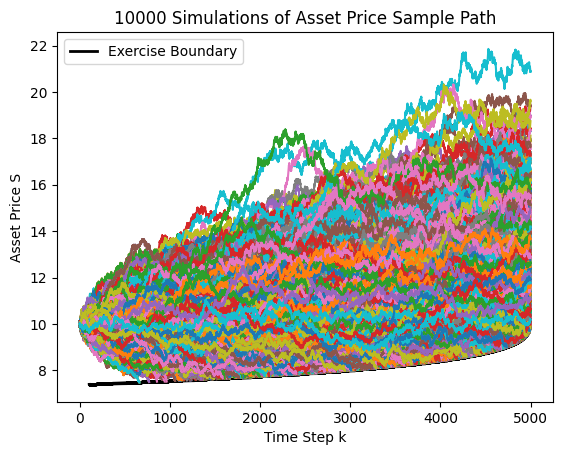

In [ ]:
# Plot the paths
fig, ax = plt.subplots()
ax.plot(bdr_b, label = 'Exercise Boundary', color = 'black', linewidth=2.0)
for i in range(0, N):
  ax.plot(m_paths[i])
ax.set_xlabel('Time Step k')
ax.set_ylabel('Asset Price S')
ax.legend(loc='upper left')
ax.set_title('10,000 Simulations of Asset Price Sample Path')

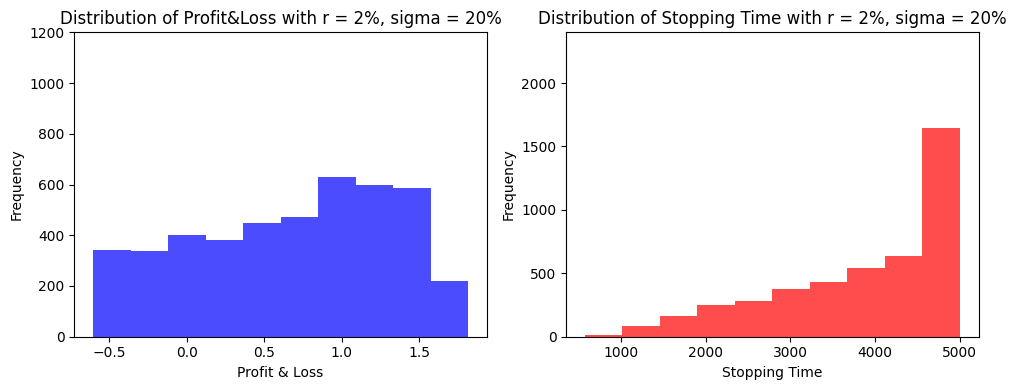

In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 2%, sigma = 20%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 2%, sigma = 20%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

In [ ]:
# Look at the probability of exercised early
p_exercise_early = exercise_count / 10000
print ("The probability of exercised early is: " + str(p_exercise_early))

The probability of exercised early is: 0.4428


## **Part 2(b) ii**
ii. Repeat the above for various values of r and σ.


In [ ]:
from itertools import product
r_list = [0.001, 0.02, 0.04]
sigma_list = [0.1, 0.2, 0.3]
pairs = list(product(r_list, sigma_list))

In [ ]:
m_paths_1, exercise_time_1, exercise_count_1, profit_loss_1 = generate_sample_path(N+1, S_1, bdr_b_1, r_1, 0.1, V0_1)

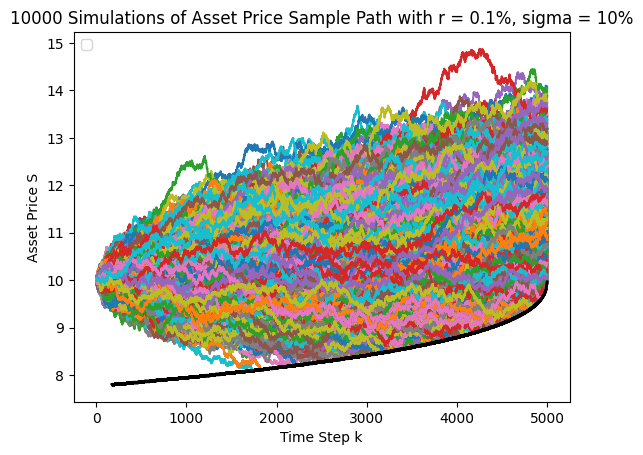

In [ ]:
# Plot the paths
fig, ax = plt.subplots()
for i in range(0, N):
  ax.plot(m_paths_1[i])
ax.set_xlabel('Time Step k')
ax.set_ylabel('Asset Price S')
ax.legend(loc='upper left')
ax.set_title('10000 Simulations of Asset Price Sample Path with r = 0.1%, sigma = 10%')
ax.plot(bdr_b_1, label = 'Exercise Boundary', color = 'black', linewidth=2.0)

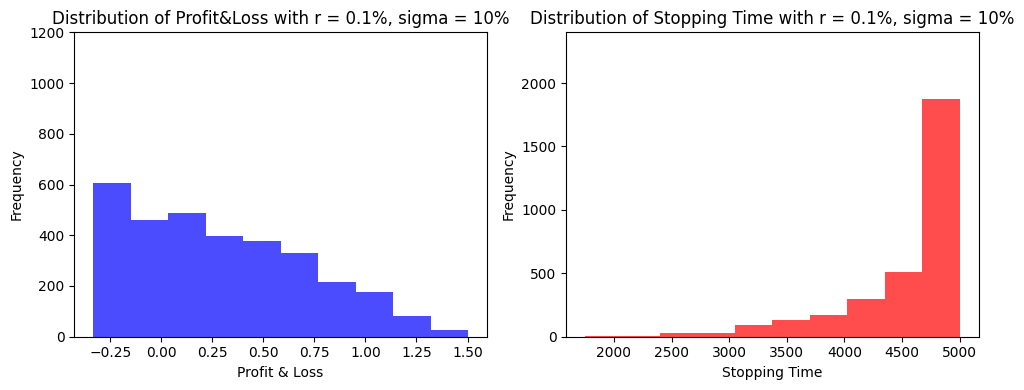

Probability of early exercise with r = 0.1%, sigma = 10% is: 0.3161


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_1, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 0.1%, sigma = 10%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_1, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 0.1%, sigma = 10%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 0.1%, sigma = 10% is: " + str(exercise_count_1/10000))

In [ ]:
m_paths_2, exercise_time_2, exercise_count_2, profit_loss_2 = generate_sample_path(N+1, S_2, bdr_b_2, 0.04, 0.3, V0_2)

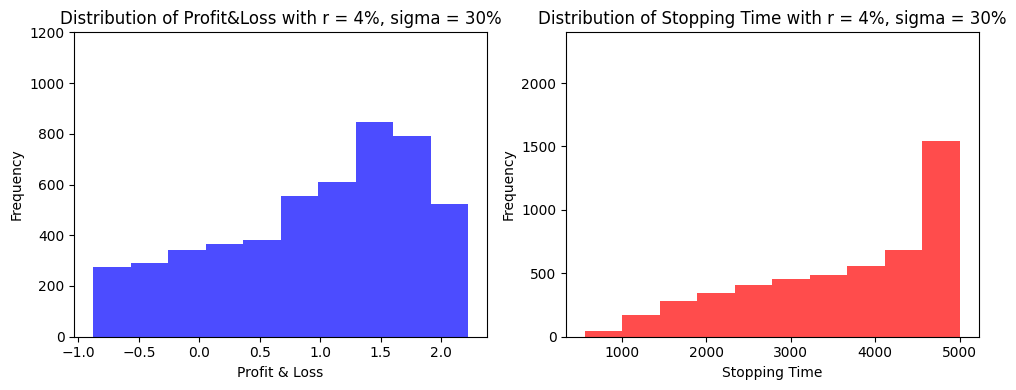

Probability of early exercise with r = 4%, sigma = 30% is: 0.4977


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_2, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 4%, sigma = 30%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_2, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 4%, sigma = 30%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 4%, sigma = 30% is: " + str(exercise_count_2/10000))

In [ ]:
bdr_b_3, bdr_s_3, S_3, V_3, Vs_3, V0_3, V0_s_3 = American_Option(T, S0, mu, sigma_list[0], r, N, K)
m_paths_3, exercise_time_3, exercise_count_3, profit_loss_3 = generate_sample_path(N+1, S_3, bdr_b_3, r, sigma_list[0], V0_3)

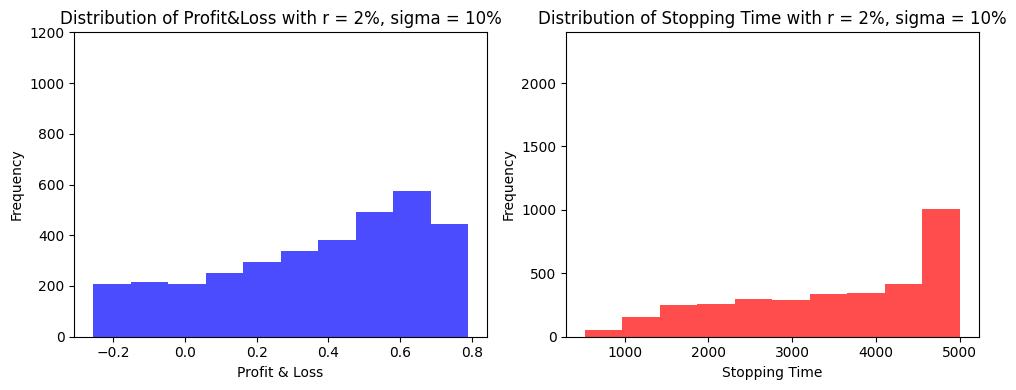

Probability of early exercise with r = 2%, sigma = 10% is: 0.3402


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_3, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 2%, sigma = 10%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_3, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 2%, sigma = 10%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 2%, sigma = 10% is: " + str(exercise_count_3/10000))

In [ ]:
bdr_b_4, bdr_s_4, S_4, V_4, Vs_4, V0_4, V0_s_4 = American_Option(T, S0, mu, sigma_list[2], r, N, K)
m_paths_4, exercise_time_4, exercise_count_4, profit_loss_4 = generate_sample_path(N+1, S_4, bdr_b_4, r, sigma_list[2], V0_4)

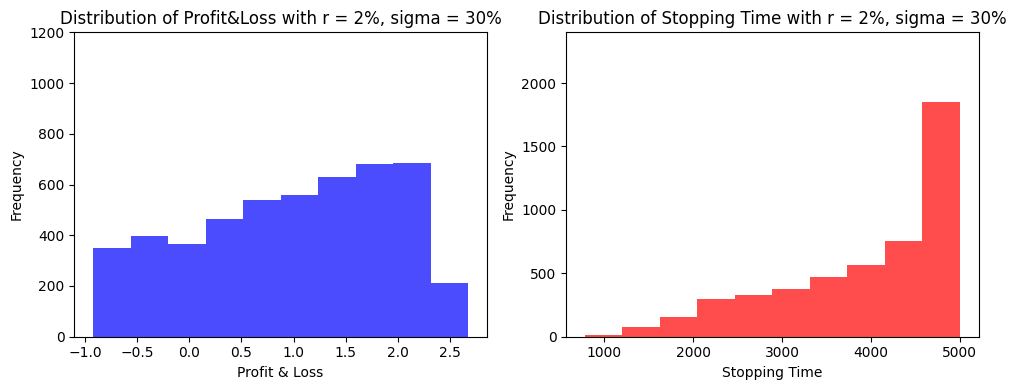

Probability of early exercise with r = 2%, sigma = 30% is: 0.4884


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_4, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 2%, sigma = 30%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_4, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 2%, sigma = 30%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 2%, sigma = 30% is: " + str(exercise_count_4/10000))

In [ ]:
bdr_b_5, bdr_s_5, S_5, V_5, Vs_5, V0_5, V0_s_5 = American_Option(T, S0, mu, sigma, r_list[0], N, K)
m_paths_5, exercise_time_5, exercise_count_5, profit_loss_5 = generate_sample_path(N+1, S_5, bdr_b_5, r_list[0], sigma, V0_5)

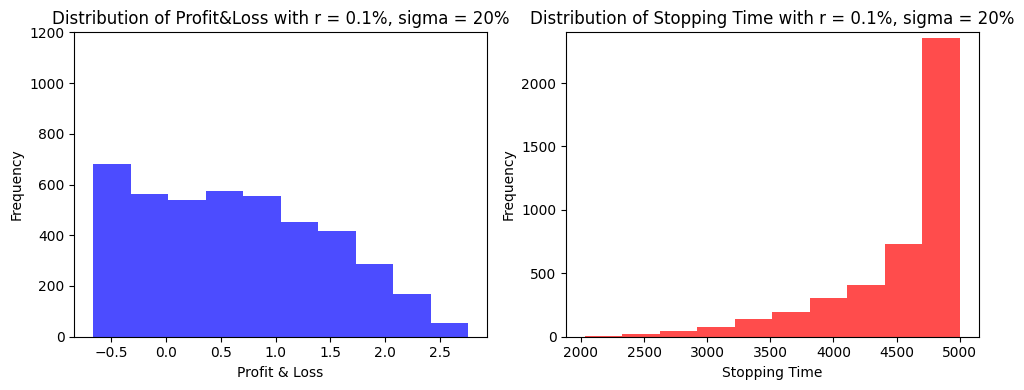

Probability of early exercise with r = 0.1%, sigma = 20% is: 0.4286


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_5, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 0.1%, sigma = 20%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_5, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 0.1%, sigma = 20%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 0.1%, sigma = 20% is: " + str(exercise_count_5/10000))

In [ ]:
bdr_b_6, bdr_s_6, S_6, V_6, Vs_6, V0_6, V0_s_6 = American_Option(T, S0, mu, sigma, r_list[2], N, K)
m_paths_6, exercise_time_6, exercise_count_6, profit_loss_6 = generate_sample_path(N+1, S_6, bdr_b_6, r_list[2], sigma, V0_6)

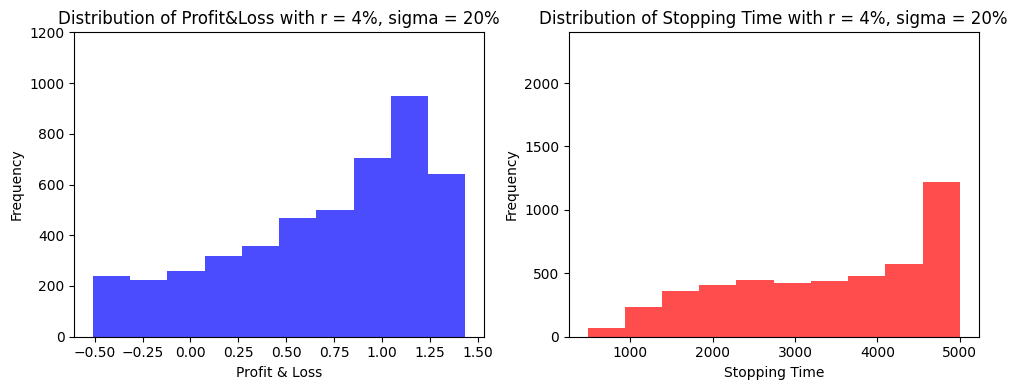

Probability of early exercise with r = 4%, sigma = 20% is: 0.4654


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_6, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 4%, sigma = 20%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_6, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 4%, sigma = 20%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 4%, sigma = 20% is: " + str(exercise_count_6/10000))

In [ ]:
bdr_b_7, bdr_s_7, S_7, V_7, Vs_7, V0_7, V0_s_7 = American_Option(T, S0, mu, sigma_list[0], r_list[2], N, K)
m_paths_7, exercise_time_7, exercise_count_7, profit_loss_7 = generate_sample_path(N+1, S_7, bdr_b_7, r_list[2], sigma_list[0], V0_7)

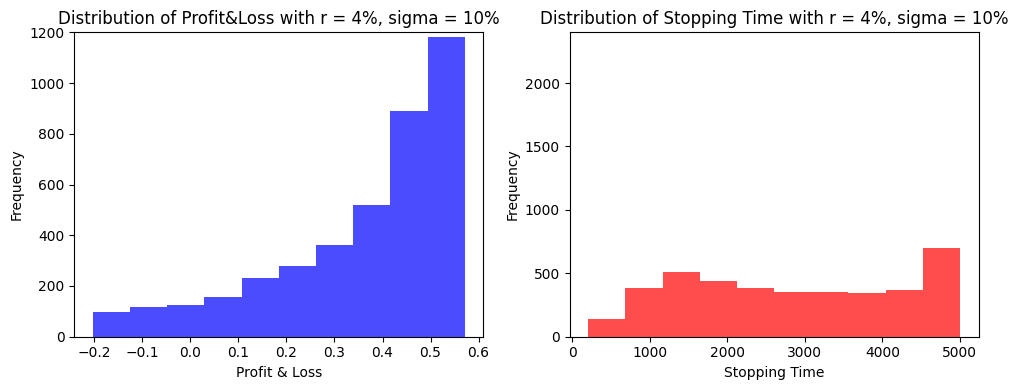

Probability of early exercise with r = 4%, sigma = 10% is: 0.3968


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_7, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 4%, sigma = 10%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_7, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 4%, sigma = 10%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2400)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 4%, sigma = 10% is: " + str(exercise_count_7/10000))

In [ ]:
bdr_b_8, bdr_s_8, S_8, V_8, Vs_8, V0_8, V0_s_8 = American_Option(T, S0, mu, sigma_list[2], r_list[0], N, K)
m_paths_8, exercise_time_8, exercise_count_8, profit_loss_8 = generate_sample_path(N+1, S_8, bdr_b_8, r_list[0], sigma_list[2], V0_8)

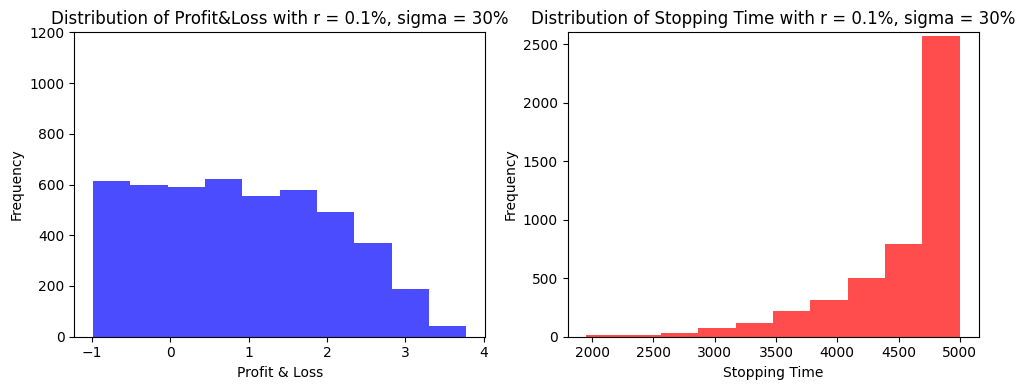

Probability of early exercise with r = 0.1%, sigma = 30% is: 0.465


In [ ]:
# plot the distribution of profit/loss
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot the histogram for x in the first subplot
axs[0].hist(profit_loss_8, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Distribution of Profit&Loss with r = 0.1%, sigma = 30%')
axs[0].set_xlabel('Profit & Loss')
axs[0].set_ylabel('Frequency')
axs[0].axis(ymax = 1200)

# Plot the histogram for y in the second subplot
axs[1].hist(exercise_time_8, bins=10, color='red', alpha=0.7)
axs[1].set_title('Distribution of Stopping Time with r = 0.1%, sigma = 30%')
axs[1].set_xlabel('Stopping Time')
axs[1].set_ylabel('Frequency')
axs[1].axis(ymax = 2600)

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

# Print the early exercise prabability
print("Probability of early exercise with r = 0.1%, sigma = 30% is: " + str(exercise_count_8/10000))

## **Part 2(b) iii**
iii. Suppose that the realized volatility is σ = 10%,15%,20%,25%,30%, but you were able to purchase the option with a volatility of σ = 20% and you use the σ = 20% exercise boundary in your trading strategy. Explore how the distributions of profit and loss and exercise time vary in this case.

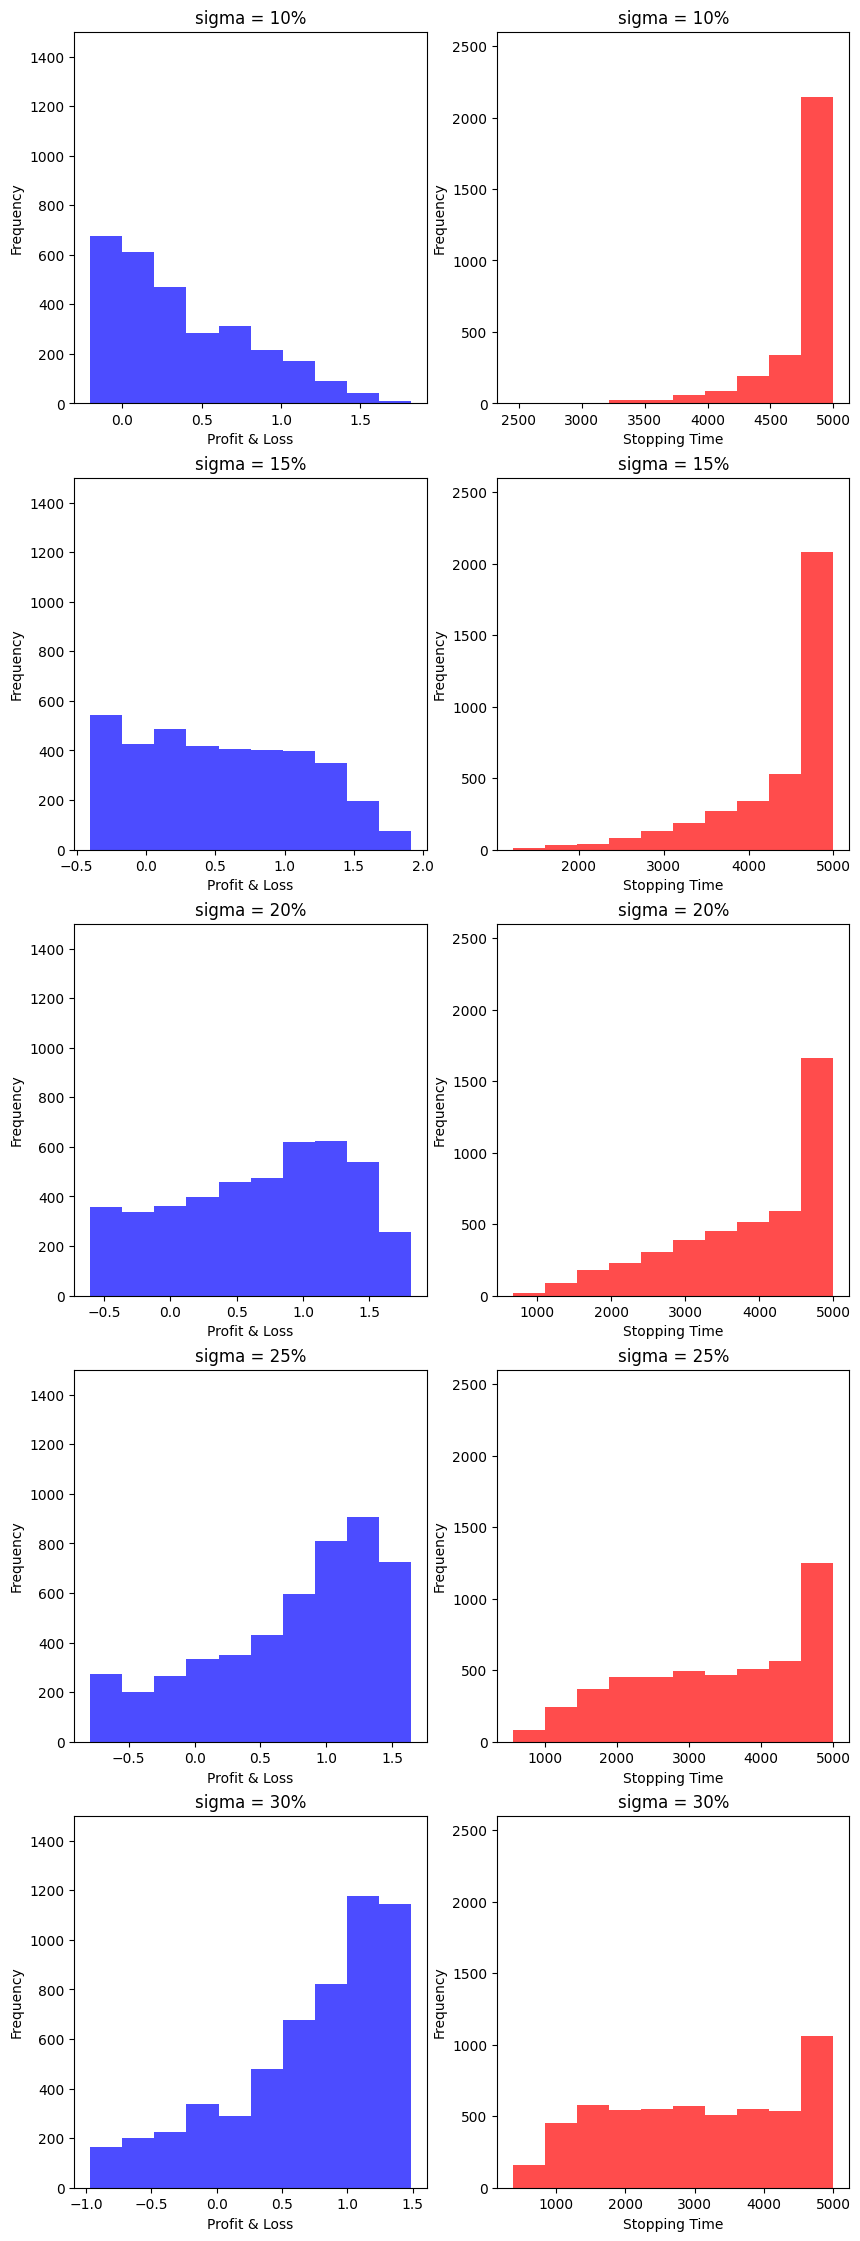

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 28))

# calculate the profit-loss and exercise time of different values of volatility
sigma_list_1 = [0.1, 0.15, 0.2, 0.25, 0.3]
for i in range(0, 5):
  realized_sigma = sigma_list_1[i]
  bdr_b_realize, bdr_s_realize, S_realize, V_realize, Vs_realize, V0_realize, V0_s_realize = American_Option(T, S0, mu, realized_sigma, r, N, K)
  m_paths_realize, exercise_time_realize, exercise_count_realize, profit_loss_realize = generate_sample_path(N+1, S_realize, bdr_b, r, realized_sigma, V0_realize)
# Plot the histograms of profit&loss in the first subplot
  axs[i, 0].hist(profit_loss_realize, bins=10, color='blue', alpha=0.7)
  axs[i, 0].set_title(f'sigma = ' + str("%g" % (realized_sigma*100)) + '%')
  axs[i, 0].set_xlabel('Profit & Loss')
  axs[i, 0].set_ylabel('Frequency')
  axs[i, 0].axis(ymax = 1500)

  # Plot the histograms of stopping time in the second subplot
  axs[i, 1].hist(exercise_time_realize, bins=10, color='red', alpha=0.7)
  axs[i, 1].set_title(f'sigma = ' + str("%g" % (realized_sigma*100)) + '%')
  axs[i, 1].set_xlabel('Stopping Time')
  axs[i, 1].set_ylabel('Frequency')
  axs[i, 1].axis(ymax = 2600)

## **Additional Figures**
Plot the option price at different volatilities.

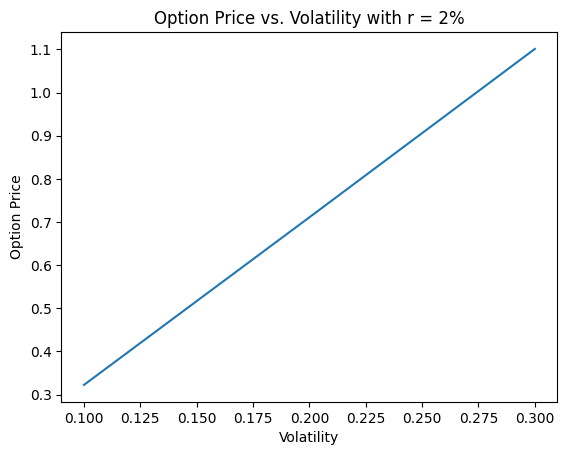

In [ ]:
# Plot the option prices of different volatilities with r = 2%
option_prices = [V0_3, V0, V0_4]

# Create a line plot
plt.plot(sigma_list, option_prices)

# Set labels and title
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.title('Option Price vs. Volatility with r = 2%')

# Show the plot
plt.show()

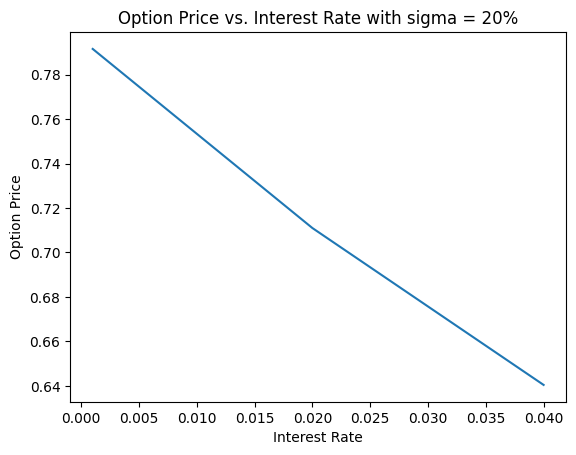

In [ ]:
# Plot the option prices of different interest rates with sigma = 20%
option_prices = [V0_5, V0, V0_6]

# Create a line plot
plt.plot(r_list, option_prices)

# Set labels and title
plt.xlabel('Interest Rate')
plt.ylabel('Option Price')
plt.title('Option Price vs. Interest Rate with sigma = 20%')

# Show the plot
plt.show()

Plot the exercise boundaries.

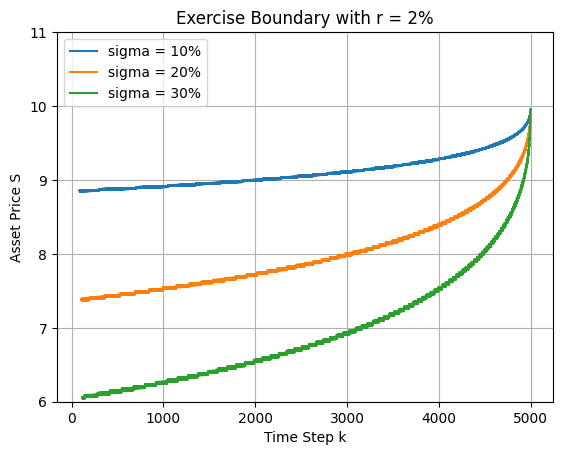

In [ ]:
#plot the boundaries at different volatilities with r = 2%
plt.ylim(6, 11)

# Plot the array
plt.plot(bdr_b_3, label = 'sigma = 10%')
plt.plot(bdr_b, label = 'sigma = 20%')
plt.plot(bdr_b_4, label = 'sigma = 30%')

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
plt.legend(loc='upper left')
plt.title('Exercise Boundary with r = 2%')

# Show the plot
plt.grid(True)
plt.show()

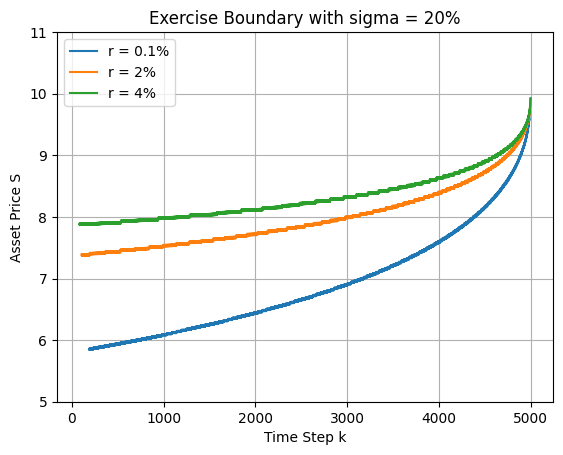

In [ ]:
#plot the boundaries with different interest rates with sigma = 20%
plt.ylim(5, 11)

# Plot the array
plt.plot(bdr_b_5, label = 'r = 0.1%')
plt.plot(bdr_b, label = 'r = 2%')
plt.plot(bdr_b_6, label = 'r = 4%')

# Add labels and legend
plt.xlabel('Time Step k')
plt.ylabel('Asset Price S')
plt.legend(loc='upper left')
plt.title('Exercise Boundary with sigma = 20%')

# Show the plot
plt.grid(True)
plt.show()